In [ ]:
#!pip install torch torchaudio librosa matplotlib scikit-learn
#!pip install torchsummary
#!pip install --upgrade numpy torchsummary
#!pip install torchviz
#!pip install torch
#!pip install torchaudio
#!pip install matplotlib

In [88]:
import os
import torch
import torchaudio
import random
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from torchsummary import summary
import matplotlib.pyplot as plt

In [73]:
config = {
    "sample_rate": 16000,
    "n_mfcc": 40,
    "n_mels": 64,
    "feature_type": "mel",  # or "mfcc"
    "num_speakers": 10,
    "max_length_per_speaker": 10.0,
    "batch_size": 32, #[16, 32, 64],
    "num_epochs": 10,
    "learning_rate": 1e-3, #[1e-3, 1e-4, 1e-5],
    "model_type": "cnn",    # ["cnn", "rnn"]
    "k_folds": 5,
    "train_vol": 0.6,
    "val_vol": 0.2,
    "test_vol": 0.2,
    "segment_duration": 3.0,
    "seed": 1234
}


In [110]:
LIBRISPEECH_DIR = "Data/train-clean-100/LibriSpeech/train-clean-100/"  

# List of speaker folders
speaker_dirs = sorted(os.listdir(LIBRISPEECH_DIR))[:config["num_speakers"]]
speaker_to_idx = {spk: idx for idx, spk in enumerate(speaker_dirs)}
print("Speaker Index Map:", speaker_to_idx)

Speaker Index Map: {'103': 0, '1034': 1, '1040': 2, '1069': 3, '1081': 4, '1088': 5, '1098': 6, '1116': 7, '118': 8, '1183': 9}


Feature Extraction

In [111]:
class LibriSpeechSpeakerDataset(Dataset):
    def __init__(self, root_dir, speaker_to_idx, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.speaker_to_idx = speaker_to_idx
        self.target_length = 800  # Fixed number of time steps (adjustable)

        for spk in speaker_to_idx.keys():
            spk_dir = os.path.join(root_dir, spk)
            for chapter in os.listdir(spk_dir):
                chapter_dir = os.path.join(spk_dir, chapter)
                for file in os.listdir(chapter_dir):
                    if file.endswith(".flac"):
                        self.samples.append({
                            "path": os.path.join(chapter_dir, file),
                            "label": speaker_to_idx[spk]
                        })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        waveform, sample_rate = torchaudio.load(sample["path"])

        # Resample to 16kHz if needed
        if sample_rate != config["sample_rate"]:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=config["sample_rate"])
            waveform = resampler(waveform)

        # Convert to Mel spectrogram (shape: [1, 64, time])
        mel_spec = MelSpectrogram(sample_rate=config["sample_rate"], n_mels=config["n_mels"])(waveform)
        mel_db = AmplitudeToDB()(mel_spec).squeeze(0)  # shape: [64, time]

        # ✅ Trim or pad to fixed width (target_length = 800)
        if mel_db.shape[1] > self.target_length:
            mel_db = mel_db[:, :self.target_length]
        else:
            pad_width = self.target_length - mel_db.shape[1]
            mel_db = torch.nn.functional.pad(mel_db, (0, pad_width))
            
        mel_db = mel_db.unsqueeze(0)  # Add this line BEFORE returning mel_db
        return mel_db, sample["label"]


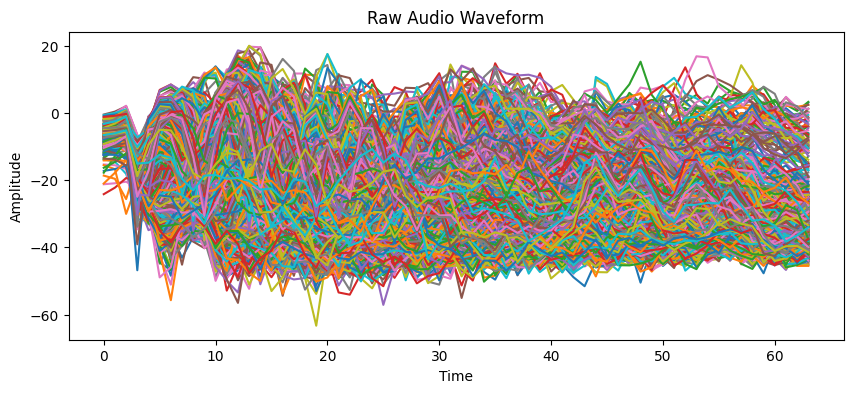

In [119]:
import torch
import torchaudio
import matplotlib.pyplot as plt

# Load an audio file (example)
#waveform, sample_rate = torchaudio.load('path_to_audio_file.wav')

dataset = LibriSpeechSpeakerDataset(LIBRISPEECH_DIR, speaker_to_idx)

# Get one sample from the dataset (first sample)
waveform, _ = dataset[0]  # _ is the label, we only need the waveform

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(waveform.squeeze().numpy())
plt.title('Raw Audio Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


In [ ]:
#from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [95]:
dataset = LibriSpeechSpeakerDataset(LIBRISPEECH_DIR, speaker_to_idx)

# Shuffle and split
train_size = int(0.6 * len(dataset))    # 60% for training
val_size = int(0.2 * len(dataset))   # 20% for validation
# val_size = len(dataset) - train_size
test_size = len(dataset) - (train_size + val_size)  # Remaining 20% for testing

# train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

# Shuffle and split the dataset
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])


#for bs in config["batch_size"]:
    #train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
    #val_loader = DataLoader(val_set, batch_size=bs)


train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_set, batch_size=config["batch_size"])
test_loader = DataLoader(test_set, batch_size=config["batch_size"])

In [101]:
class SpeakerCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5): # Add dropout_rate as a parameter
        super().__init__()
        
        # Step 1: Define your conv layers first
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Dynamically calculate flattened size after conv layers
        n_size = self._get_conv_output((1, 64, 800))
        self.fc1 = nn.Linear(n_size, 128)
        self.dropout = nn.Dropout(p=dropout_rate)  # Add dropout layer

        self.fc2 = nn.Linear(128, num_classes)

    def _get_conv_output(self, shape):
        bs = 1
        input = torch.rand(bs, *shape)
        output_feat = self.conv_layers(input)
        n_size = output_feat.view(bs, -1).size(1)
        return n_size

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)  # Apply dropout after the fully connected layer
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
#import torchaudio
#print(torchaudio.list_audio_backends())

[]


In [ ]:
#import torchaudio
#torchaudio.set_audio_backend("sox_io")  # or "ffmpeg" if you used that before

#import torchaudio
#torchaudio.set_audio_backend("ffmpeg")

C:\Users\h_ale\AppData\Local\Temp\ipykernel_30404\522754334.py:5: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("ffmpeg")


In [ ]:
#print(torchaudio.get_audio_backend())  # should print 'ffmpeg'

None


C:\Users\h_ale\AppData\Local\Temp\ipykernel_30404\1623447431.py:1: UserWarning: torchaudio._backend.get_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  print(torchaudio.get_audio_backend())  # should print 'ffmpeg'


In [102]:
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Create model
model = SpeakerCNN(num_classes=config["num_speakers"]).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

# Training loop
num_epochs = config["num_epochs"]
    
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for mel, labels in train_loader:
        mel = mel.to(device)  # shape: [batch_size, 64, 800]
        labels = labels.to(device)

        outputs = model(mel)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

Using device: cpu
Epoch [1/10] - Loss: 40.1145, Accuracy: 15.08%
Epoch [2/10] - Loss: 1.6355, Accuracy: 37.62%
Epoch [3/10] - Loss: 1.0750, Accuracy: 60.79%
Epoch [4/10] - Loss: 0.5277, Accuracy: 82.06%
Epoch [5/10] - Loss: 0.2679, Accuracy: 91.43%
Epoch [6/10] - Loss: 0.2177, Accuracy: 92.86%
Epoch [7/10] - Loss: 0.1482, Accuracy: 94.29%
Epoch [8/10] - Loss: 0.1142, Accuracy: 95.71%
Epoch [9/10] - Loss: 0.0911, Accuracy: 97.30%
Epoch [10/10] - Loss: 0.1360, Accuracy: 95.87%


In [103]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for mel, labels in val_loader:
        mel, labels = mel.to(device), labels.to(device)
        outputs = model(mel)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Validation Accuracy: {100 * correct / total:.2f}%")


Validation Accuracy: 92.38%


In [104]:
# Test the model on the unseen test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for mel, labels in test_loader:
        mel, labels = mel.to(device), labels.to(device)
        outputs = model(mel)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Print test accuracy
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 87.14%


In [105]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have predicted the labels for validation or test set
model.eval()  # Switch to evaluation mode
y_true = []
y_pred = []

# Collect true labels and predicted labels
with torch.no_grad():
    for mel, labels in test_loader:  # Or val_loader
        mel, labels = mel.to(device), labels.to(device)
        outputs = model(mel)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())  # Get true labels
        y_pred.extend(predicted.cpu().numpy())  # Get predicted labels

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # Use 'macro', 'micro', or 'weighted' based on your needs
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8714
Precision: 0.8772
Recall: 0.8714
F1 Score: 0.8671


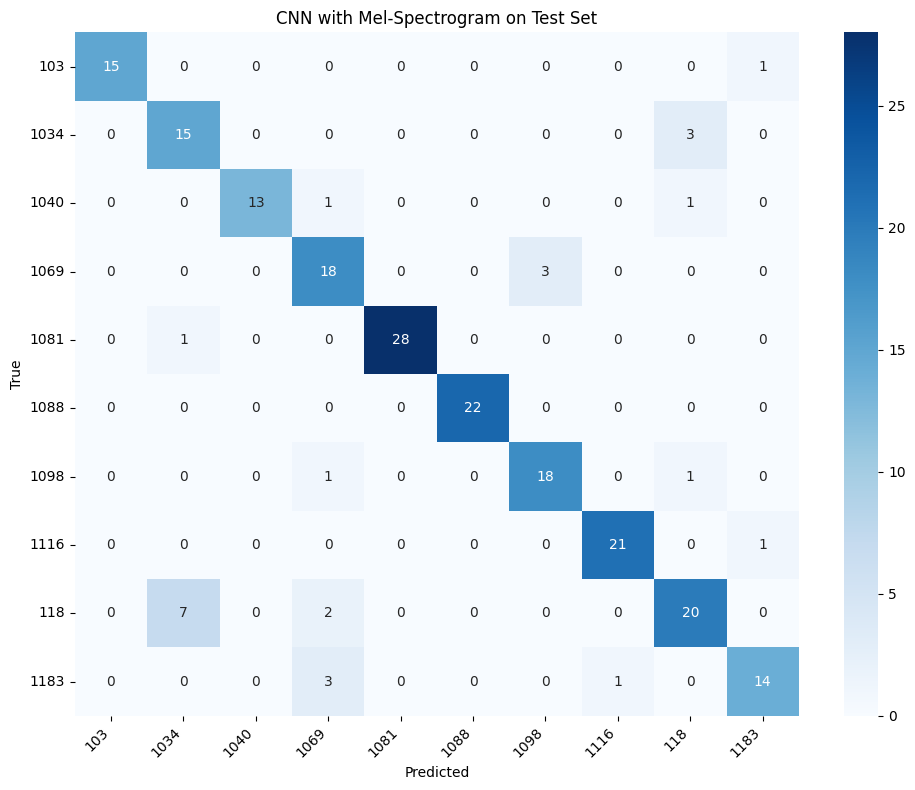

In [89]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Put model in evaluation mode
model.eval()

# Store all predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for mel, labels in test_loader: #val_loader:
        mel, labels = mel.to(device), labels.to(device)
        outputs = model(mel)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optional: normalize confusion matrix (row-wise)
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=list(speaker_to_idx.keys()), 
            yticklabels=list(speaker_to_idx.keys()))
plt.title("CNN with Mel-Spectrogram on Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


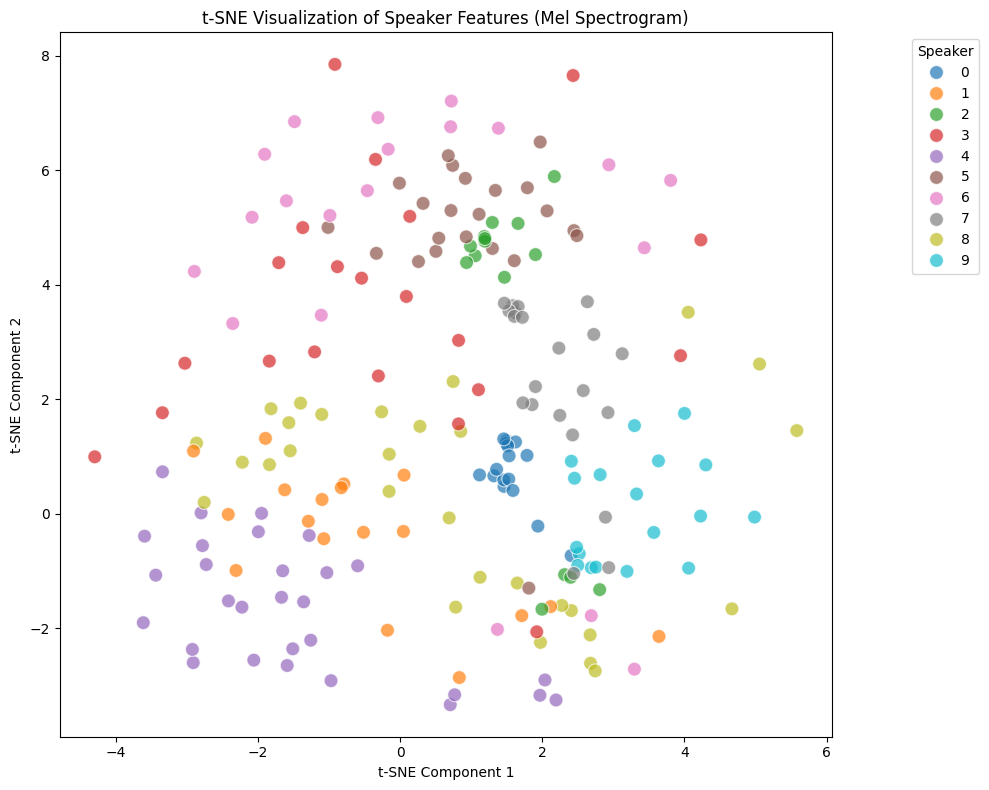

In [91]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Function to extract features from the model (without final classification layer)
def extract_features(model, data_loader, device):
    features = []
    labels = []
    model.eval()

    with torch.no_grad():
        for mel, label in data_loader:
            mel = mel.to(device)
            label = label.to(device)
            # Pass through the CNN layers (not the final classification layers)
            x = model.conv_layers(mel)
            x = x.view(x.size(0), -1)  # Flatten the output of conv layers
            features.extend(x.cpu().numpy())
            labels.extend(label.cpu().numpy())

    return np.array(features), np.array(labels)

# Extract features from validation set
features, labels = extract_features(model, test_loader, device)

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=config["seed"])
tsne_results = tsne.fit_transform(features)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette="tab10", s=100, alpha=0.7)

# Customize plot
plt.title("t-SNE Visualization of Speaker Features (Mel Spectrogram)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Speaker", loc="upper right", bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()


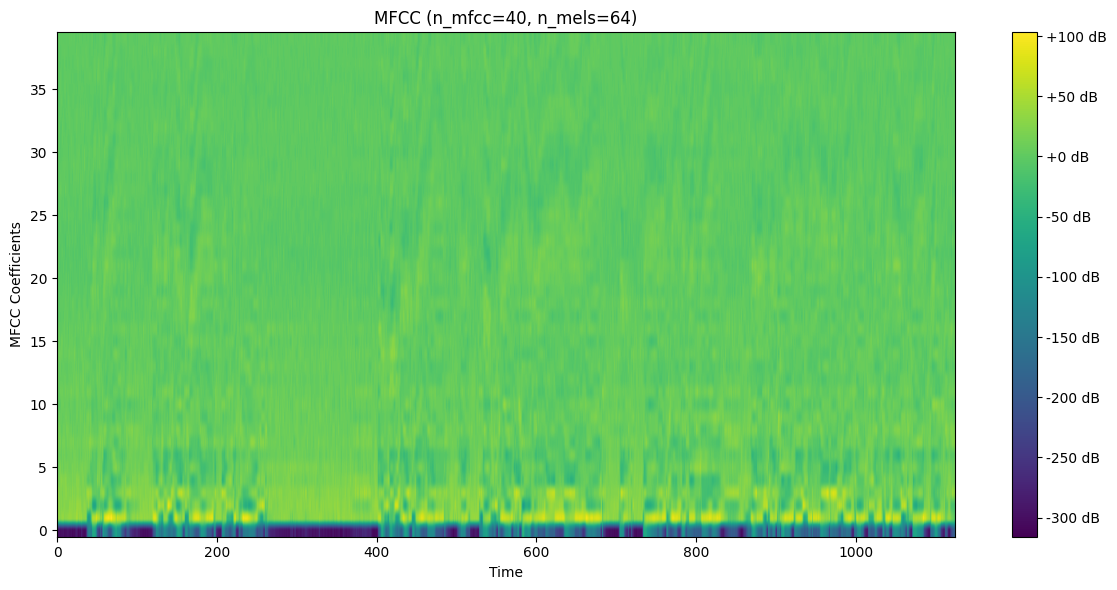

In [59]:
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt

# Function to plot MFCCs from a sample audio file
#def plot_mfcc(audio_path, sample_rate=16000, n_mfcc=40):
def plot_mfcc(audio_path, sample_rate=16000, n_mfcc=40, n_mels=64):
    waveform, sr = torchaudio.load(audio_path)
    
    # Resample if needed
    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
        waveform = resampler(waveform)
    
    # Apply MFCC transform
    mfcc = T.MFCC(
        sample_rate=sample_rate, 
        n_mfcc=n_mfcc, 
        melkwargs={"n_mels": n_mels, "center": False}
        #melkwargs={"n_mels": 23, "center": False}
    )(waveform)

    # Plot MFCCs
    plt.figure(figsize=(12, 6))
    plt.imshow(mfcc[0].detach().numpy(), cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"MFCC (n_mfcc={n_mfcc}, n_mels={n_mels})")
    #plt.title("MFCC (Mel-Frequency Cepstral Coefficients)")
    plt.xlabel("Time")
    plt.ylabel("MFCC Coefficients")
    plt.tight_layout()
    plt.show()

# Example: Plot MFCC for a random audio sample from your dataset
audio_path = "Data/train-clean-100/LibriSpeech/train-clean-100/103/1240/103-1240-0000.flac"  # Replace with an actual path
plot_mfcc(audio_path)
#print(os.path.exists(audio_path))


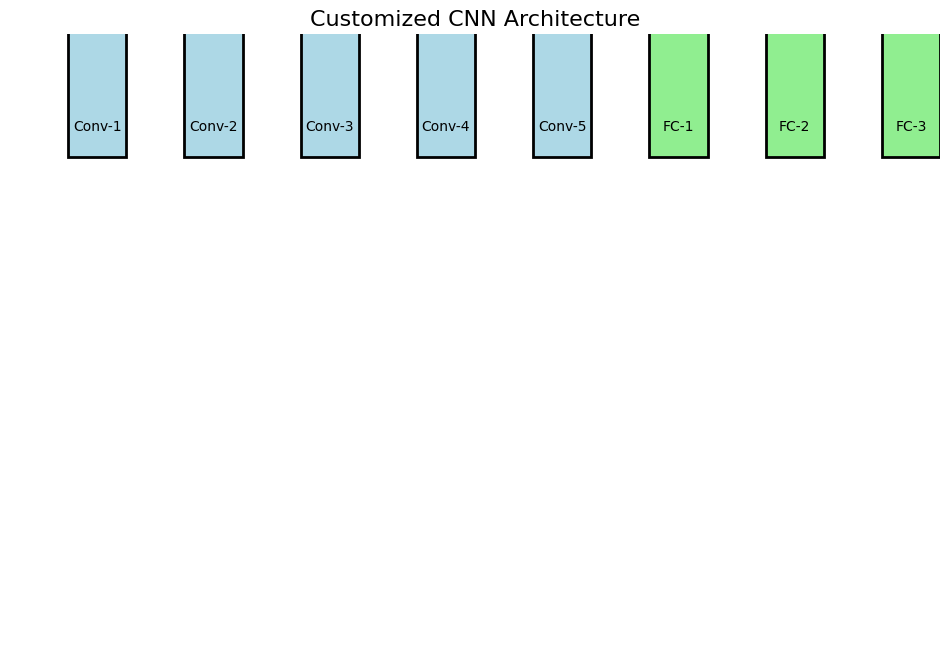

In [64]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_cnn_architecture():
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot layers as rectangles
    layers = [
        {"name": "Conv-1", "color": "lightblue", "size": (1, 16), "position": (1, 8)},
        {"name": "Conv-2", "color": "lightblue", "size": (1, 32), "position": (3, 8)},
        {"name": "Conv-3", "color": "lightblue", "size": (1, 64), "position": (5, 8)},
        {"name": "Conv-4", "color": "lightblue", "size": (1, 128), "position": (7, 8)},
        {"name": "Conv-5", "color": "lightblue", "size": (1, 256), "position": (9, 8)},
        {"name": "FC-1", "color": "lightgreen", "size": (1, 512), "position": (11, 8)},
        {"name": "FC-2", "color": "lightgreen", "size": (1, 128), "position": (13, 8)},
        {"name": "FC-3", "color": "lightgreen", "size": (1, 10), "position": (15, 8)}  # num_speakers = 10
    ]

    # Add each layer as a colored rectangle
    for layer in layers:
        ax.add_patch(patches.Rectangle(
            layer["position"], layer["size"][0], layer["size"][1],
            edgecolor='black', facecolor=layer["color"], lw=2
        ))
        ax.text(layer["position"][0] + 0.5, layer["position"][1] + 0.5, 
                layer["name"], horizontalalignment='center', 
                verticalalignment='center', fontsize=10, color='black')

    # Add arrows to show data flow
    for i in range(len(layers) - 1):
        start_pos = (layers[i]["position"][0] + layers[i]["size"][0], layers[i]["position"][1] + layers[i]["size"][1] / 2)
        end_pos = (layers[i + 1]["position"][0], layers[i + 1]["position"][1] + layers[i + 1]["size"][1] / 2)
        ax.annotate("", xy=end_pos, xytext=start_pos,
                    arrowprops=dict(arrowstyle="->", lw=2))

    # Set limits and remove axes
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 10)
    ax.axis("off")

    plt.title("Customized CNN Architecture", fontsize=16)
    plt.show()

# Call function to plot architecture
plot_cnn_architecture()





In [11]:
torch.save(model.state_dict(), "speaker_recognition_model.pth")

In [11]:
#summary(model.to("cpu"), input_size=(1, 64, 800), device="cpu")

# Show model architecture and parameter sizes (example input: [1, 1, 64, 800])
summary(model, input_size=(1, 64, 800))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 64, 800]             160
              ReLU-2          [-1, 16, 64, 800]               0
         MaxPool2d-3          [-1, 16, 32, 400]               0
            Conv2d-4          [-1, 32, 32, 400]           4,640
              ReLU-5          [-1, 32, 32, 400]               0
         MaxPool2d-6          [-1, 32, 16, 200]               0
            Linear-7                  [-1, 128]      13,107,328
            Linear-8                   [-1, 10]           1,290
Total params: 13,113,418
Trainable params: 13,113,418
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.20
Forward/backward pass size (MB): 21.09
Params size (MB): 50.02
Estimated Total Size (MB): 71.31
----------------------------------------------------------------


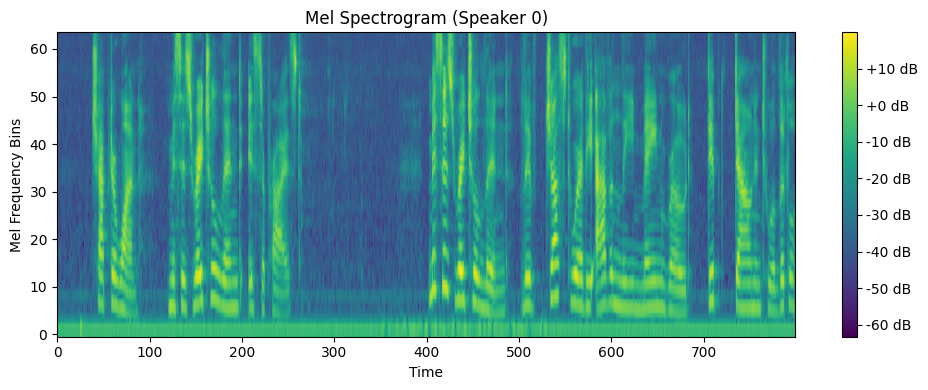

In [12]:
# Get a sample mel spectrogram from your dataset
sample_mel, sample_label = dataset[0]  # First sample
sample_mel = sample_mel.squeeze(0)     # Remove channel dim → [64, time]

# Plot it
plt.figure(figsize=(10, 4))
plt.imshow(sample_mel.numpy(), aspect='auto', origin='lower')
plt.title(f"Mel Spectrogram (Speaker {sample_label})")
plt.xlabel("Time")
plt.ylabel("Mel Frequency Bins")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

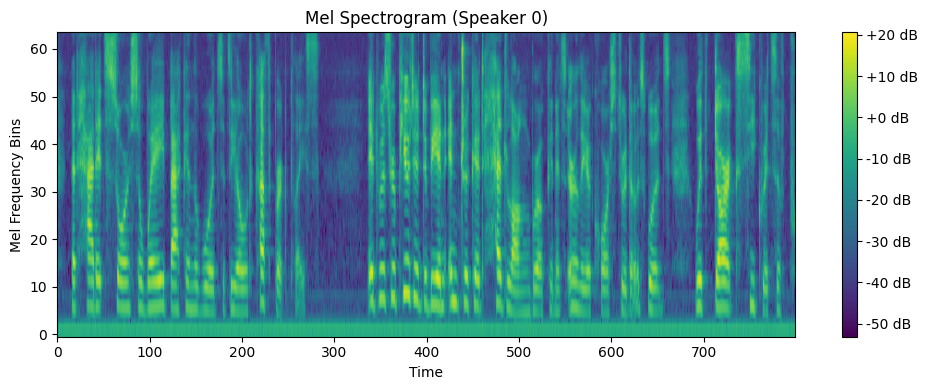

In [13]:
#import matplotlib.pyplot as plt

# Get a sample mel spectrogram from your dataset
sample_mel, sample_label = dataset[1]  # First sample
sample_mel = sample_mel.squeeze(0)     # Remove channel dim → [64, time]

# Plot it
plt.figure(figsize=(10, 4))
plt.imshow(sample_mel.numpy(), aspect='auto', origin='lower')
plt.title(f"Mel Spectrogram (Speaker {sample_label})")
plt.xlabel("Time")
plt.ylabel("Mel Frequency Bins")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [14]:
#import torch
import torch.nn as nn
#import torch.nn.functional as F

# Define a CNN model similar to the architecture shown in the image
class CNNModel(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=5, padding=2)  # n1 filters
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)              # n2 filters

        self.fc1 = nn.Linear(64 * 7 * 7, 256)  # adjust based on input size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + ReLU + MaxPool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + ReLU + MaxPool
        x = x.view(-1, 64 * 7 * 7)            # Flatten
        x = F.relu(self.fc1(x))               # FC1 + ReLU
        x = self.dropout(x)
        x = self.fc2(x)                       # FC2
        return x

model = CNNModel()
print(model)


CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [15]:
# Optional: visualize model graph with torchviz
import torch
import torch.nn.functional as F
from torchviz import make_dot

x = torch.randn(1, 1, 28, 28)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()))).render("cnn_architecture", format="png")

'cnn_architecture.png'

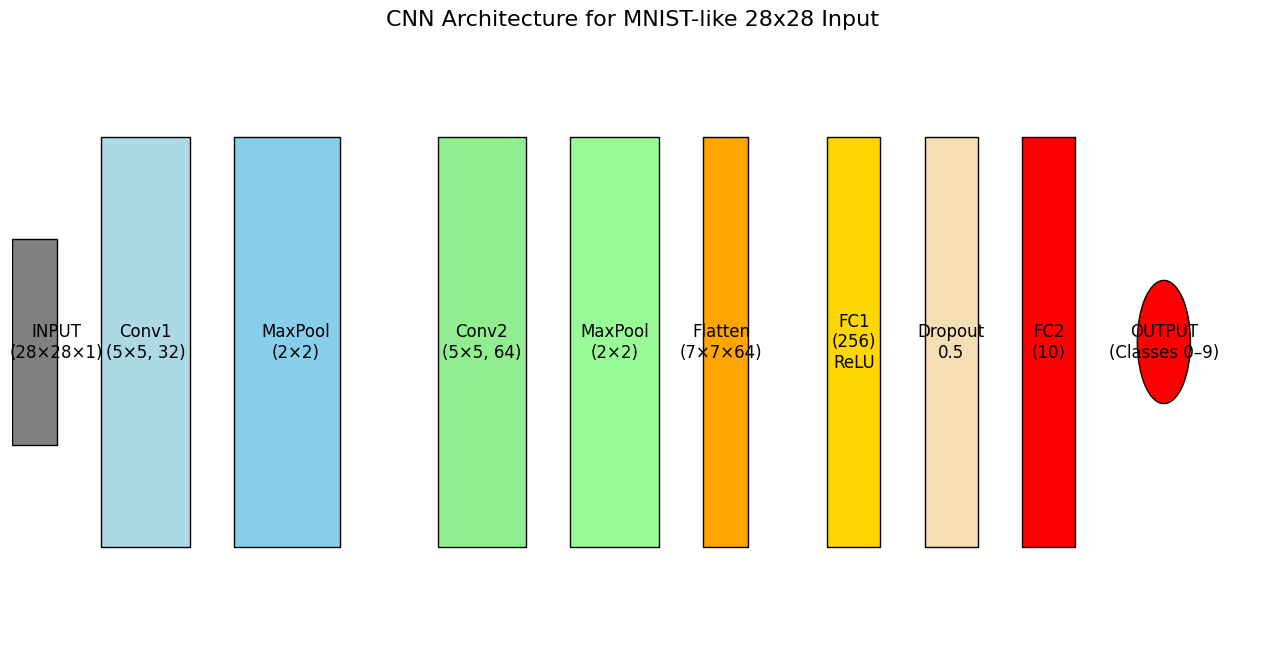

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_cnn_architecture():
    fig, ax = plt.subplots(figsize=(16, 8))

    # INPUT
    ax.text(0.5, 5.5, 'INPUT\n(28×28×1)', ha='center', va='center', fontsize=12)
    ax.add_patch(patches.Rectangle((0, 5), 0.5, 1, edgecolor='black', facecolor='gray'))

    # Conv1
    ax.text(1.5, 5.5, 'Conv1\n(5×5, 32)', ha='center', va='center', fontsize=12)
    ax.add_patch(patches.Rectangle((1, 4.5), 1, 2, edgecolor='black', facecolor='lightblue'))

    # MaxPool1
    ax.text(3.2, 5.5, 'MaxPool\n(2×2)', ha='center', va='center', fontsize=12)
    ax.add_patch(patches.Rectangle((2.5, 4.5), 1.2, 2, edgecolor='black', facecolor='skyblue'))

    # Conv2
    ax.text(5.3, 5.5, 'Conv2\n(5×5, 64)', ha='center', va='center', fontsize=12)
    ax.add_patch(patches.Rectangle((4.8, 4.5), 1, 2, edgecolor='black', facecolor='lightgreen'))

    # MaxPool2
    ax.text(6.8, 5.5, 'MaxPool\n(2×2)', ha='center', va='center', fontsize=12)
    ax.add_patch(patches.Rectangle((6.3, 4.5), 1, 2, edgecolor='black', facecolor='palegreen'))

    # Flatten
    ax.text(8.0, 5.5, 'Flatten\n(7×7×64)', ha='center', va='center', fontsize=12)
    ax.add_patch(patches.Rectangle((7.8, 4.5), 0.5, 2, edgecolor='black', facecolor='orange'))

    # FC1
    ax.text(9.5, 5.5, 'FC1\n(256)\nReLU', ha='center', va='center', fontsize=12)
    ax.add_patch(patches.Rectangle((9.2, 4.5), 0.6, 2, edgecolor='black', facecolor='gold'))

    # Dropout
    ax.text(10.6, 5.5, 'Dropout\n0.5', ha='center', va='center', fontsize=12)
    ax.add_patch(patches.Rectangle((10.3, 4.5), 0.6, 2, edgecolor='black', facecolor='wheat'))

    # FC2
    ax.text(11.7, 5.5, 'FC2\n(10)', ha='center', va='center', fontsize=12)
    ax.add_patch(patches.Rectangle((11.4, 4.5), 0.6, 2, edgecolor='black', facecolor='red'))

    # OUTPUT
    ax.text(13.0, 5.5, 'OUTPUT\n(Classes 0–9)', ha='center', va='center', fontsize=12)
    ax.add_patch(patches.Circle((13, 5.5), 0.3, edgecolor='black', facecolor='red'))

    ax.set_xlim(0, 14)
    ax.set_ylim(4, 7)
    ax.axis('off')
    plt.title("CNN Architecture for MNIST-like 28x28 Input", fontsize=16)
    plt.show()

draw_cnn_architecture()
